# 循环神经网络

## 动手实现循环神经网络

In [1]:
import math

import torch
from torch import nn
import numpy as np

from dataset.dataset import *

观察RNN的计算公式：
$$h_t=\sigma (W_h x_t+U_h h_{t-1} + b_h),\ y_t=\sigma (W_y h_t+b_y)$$
其中$x_t$是t步的输入；$h_t$是t步的隐藏状态，需要我们初始化，并在每步间循环更新；$W_h,W_y,b_h,b_y$则是可学习参数；$\sigma$是激活函数，计算新的隐藏状态时一般使用Tanh，计算状态时需要考虑我们期望的输出的范围。例如，希望输出为非负，则使用ReLU。

为了方便管理，我们将所有参数和计算过程集中在一个类中。

In [2]:
class MyRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        """
        :param input_size: 指定输入数据的维度。例如，对于简单的时间序列预测问题，每一步的输入均为一个采样值，因此input_size=1.
        :param hidden_size: 指定隐藏状态的维度。这个值并不受输入和输出控制，但会影响模型的容量。
        :param output_size: 指定输出数据的维度。此值取决于具体的预测要求。例如，对简单的时间序列预测问题，output_size=1.
        """
        super().__init__()
        self.hidden_size = hidden_size
        
        # 可学习参数的维度设置，可以类比一下全连接网络的实现。其维度取决于输入数据的维度，以及指定的隐藏状态维度。
        self.w_h = nn.Parameter(torch.rand(input_size, hidden_size))
        self.u_h = nn.Parameter(torch.rand(hidden_size, hidden_size))
        self.b_h = nn.Parameter(torch.zeros(hidden_size))
        
        self.w_y = nn.Parameter(torch.rand(hidden_size, output_size))
        self.b_y = nn.Parameter(torch.zeros(output_size))
        
        # 准备激活函数。Dropout函数可选。
        self.tanh = nn.Tanh()
        self.leaky_relu = nn.LeakyReLU()
        
        # 可选：使用性能更好的参数初始化函数
        for param in self.parameters():
            if param.dim() > 1:
                nn.init.xavier_uniform_(param)
                
    def forward(self, x):
        """
        :param x: 输入序列。一般来说，此输入包含三个维度：batch，序列长度，以及每条数据的特征。
        """
        batch_size = x.size(0)
        seq_len = x.size(1)
        
        # 初始化隐藏状态，一般设为全0。由于是内部新建的变量，需要同步设备位置。
        h = torch.zeros(batch_size, self.hidden_size).to(x.device)
        # RNN实际上只能一步一步处理序列。因此需要用循环迭代。
        y_list = []
        for i in range(seq_len):
            h = self.tanh(torch.matmul(x[:, i, :], self.w_h) + 
                             torch.matmul(h, self.u_h) + self.b_h)  # (batch_size, hidden_size)
            y = self.leaky_relu(torch.matmul(h, self.w_y) + self.b_y)  # (batch_size, output_size)
            y_list.append(y)
        # 一般来说，RNN的返回值为最后一步的隐藏状态，以及每一步的输出状态。
        return h, torch.stack(y_list, dim=1)

使用随机生成的数据进行简单的测试：

In [3]:
device = 'cuda:0'  # 如果电脑上无Nvidia显卡或未安装CUDA框架，请更改为 'cpu'
batch_size = 64
seq_len = 12
input_size = 2
hidden_size = 32
output_size = 1

x = torch.rand(batch_size, seq_len, input_size).to(device)
rnn = MyRNN(input_size, hidden_size, output_size).to(device)
hidden, y = rnn(x)
print(hidden.shape, y.shape)

torch.Size([64, 32]) torch.Size([64, 12, 1])


## 使用RNN进行实验

结合上一章的数据处理方式，首先将原始数据处理为短序列，随后以batch的形式进行训练，并在测试集上计算结果。

### 数据处理

In [4]:
# 读取数据
dataset = KrakowDataset()
raw_df = dataset.data
raw_df.dropna().head()

C:\Users\loganlin\Documents\Code\Python\Class\deeplearning2020\dataset\dataset.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  this_sensor['sensor_index'] = id2index[sensor_id]


,sensor_index,UTC time,temperature,humidity,pressure,pm1,pm25,pm10
395,0,2017-01-17 11:00:00,0.323529,0.971508,0.482360,0.068882,0.289673,0.186466
396,0,2017-01-17 12:00:00,0.294118,0.973699,0.484556,0.060778,0.264484,0.174436
397,0,2017-01-17 13:00:00,0.294118,0.973890,0.487776,0.035656,0.156171,0.117293
398,0,2017-01-17 14:00:00,0.279412,0.974271,0.491729,0.038898,0.171285,0.129323
399,0,2017-01-17 15:00:00,0.279412,0.974557,0.497731,0.040519,0.178841,0.133835


我们选择temperature这一列进行预测。对于空缺的数据，我们采用线性插分的方式进行处理。

每个传感器的完整序列可以看作是一条长序列。

In [5]:
def sliding_window(seq, window_size):
    result = []
    for i in range(len(seq) - window_size + 1):
        result.append(seq[i:i+window_size])
    return result

fetch_col = 'temperature'
train_set, test_set = [], []
for sensor_index, group in raw_df.groupby('sensor_index'):
    full_seq = group[fetch_col].interpolate(method='linear', limit=3, limit_area='outside')
    full_len = full_seq.shape[0]
    train_seq, test_seq = full_seq.iloc[:int(full_len * 0.8)].to_list(),\
                          full_seq.iloc[int(full_len * 0.8):].to_list()
    train_set += sliding_window(train_seq, window_size=13)
    test_set += sliding_window(test_seq, window_size=13)

# 即使使用了线性插分，依然可能会有缺失值。这里选择直接抛弃。
train_set, test_set = np.array(train_set), np.array(test_set)
train_set, test_set = (item[~np.isnan(item).any(axis=1)] for item in (train_set, test_set))
print(train_set.shape, test_set.shape)

(276923, 13) (72361, 13)


为了保证模型能够正常训练，模型的输入需要进行归一化。我们已经在dataset.dataset.KrakowDataset的初始化过程中进行了归一化。

在测试模型时，需要将数据反归一化以得到正常的测试结果。

### 模型初始化

为了能够实现可学习参数的更新，我们还需要提供合理的损失函数和优化器。

损失函数应当按照具体任务选择，对于我们这里的回归问题，一般使用MSELoss。

优化器可以从torch.optim中选择。我们这里选择Adam优化器。优化器初始化时，需要提供所有需要优化的参数。由于我们将模型放入了一个nn.Module的子类中，直接使用model.parameters()就可以得到所有参数。

In [6]:
device = 'cuda:0'
model = MyRNN(input_size=1, hidden_size=32, output_size=1).to(device)

loss_func = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

> 顺便一说，如果需要同时优化多个模型的参数，使用下面的语句即可：

    model_a = MyRNN(input_size=1, hidden_size=32, output_size=1).to(device)
    model_b = MyRNN(input_size=1, hidden_size=32, output_size=1).to(device)
    optimizer = torch.optim.Adam(list(model_a.parameters()) + list(model_b.parameters())
    
> 这是因为model.parameters()是一个生成器，因此可以用list()得到所有参数的列表，然后用相加操作即可。

为了能够测试模型的预测性能，也需要选择一个或多个测试指标。指标的选择取决于具体任务。对于回归任务，一般使用RMSE、MAE和MAPE。

Scikit-learn中提供了MAE和MSE。RMSE可以通过再MSE上求根得到，MAPE则需要自己实现。

In [7]:
from sklearn.metrics import mean_squared_error as mse, mean_absolute_error as mae


def mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    non_zero_index = (y_true > 0)
    y_true = y_true[non_zero_index]
    y_pred = y_pred[non_zero_index]

    mape = np.abs((y_true - y_pred) / y_true)
    mape[np.isinf(mape)] = 0
    return np.mean(mape) * 100

### 进行训练

一般来说，为了平衡收敛速度和硬件需求，我们采用batch的形式进行训练。这里使用一个自己实现的next_batch函数实现从完整的训练/测试集中按序列取batch。

In [8]:
def next_batch(data, batch_size):
    data_length = len(data)
    num_batches = math.ceil(data_length / batch_size)
    for batch_index in range(num_batches):
        start_index = batch_index * batch_size
        end_index = min((batch_index + 1) * batch_size, data_length)
        yield data[start_index:end_index]

对于RNN的输出如何处理，也取决于具体的任务和模型设计。这里我们直接将RNN输出状态的最后一步作为对下一消失温度的预测，因为最后一步输出理论上包含了整个输入历史序列的信息。

In [9]:
from sklearn.utils import shuffle

loss_log = []
score_log = []
trained_batches = 0
for epoch in range(10):
    for batch in next_batch(shuffle(train_set), batch_size=64):
        batch = torch.from_numpy(batch).float().to(device)  # (batch, seq_len)
        # 使用短序列的前12个值作为历史，最后一个值作为预测值。
        x, label = batch[:, :12], batch[:, -1]
        
        hidden, out = model(x.unsqueeze(-1))
        prediction = out[:, -1, :].squeeze(-1)  # (batch)
        
        loss = loss_func(prediction, label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_log.append(loss.detach().cpu().numpy().tolist())
        trained_batches += 1
        
        # 每训练一定数量的batch，就在测试集上测试模型效果。
        if trained_batches % 100 == 0:
            all_prediction = []
            for batch in next_batch(test_set, batch_size=64):
                batch = torch.from_numpy(batch).float().to(device)  # (batch, seq_len)
                x, label = batch[:, :12], batch[:, -1]
                
                hidden, out = model(x.unsqueeze(-1))
                prediction = out[:, -1, :].squeeze(-1)  # (batch)
                all_prediction.append(prediction.detach().cpu().numpy())
            all_prediction = np.concatenate(all_prediction)
            all_label = test_set[:, -1]
            # 进行反归一化操作。
            all_prediction = dataset.denormalize(all_prediction, fetch_col)
            all_label = dataset.denormalize(all_label, fetch_col)
            # 计算测试指标。
            rmse_score = math.sqrt(mse(all_label, all_prediction))
            mae_score = mae(all_label, all_prediction)
            mape_score = mape(all_label, all_prediction)
            score_log.append([rmse_score, mae_score, mape_score])
            print('RMSE: %.4f, MAE: %.4f, MAPE: %.4f' % (rmse_score, mae_score, mape_score))

best_score = np.min(score_log, axis=0)

RMSE: 4.2181, MAE: 3.6064, MAPE: 114.3538
RMSE: 3.4759, MAE: 2.9394, MAPE: 92.7731
RMSE: 2.4627, MAE: 1.9056, MAPE: 57.5355
RMSE: 2.0321, MAE: 1.4485, MAPE: 42.7023
RMSE: 1.8351, MAE: 1.2297, MAPE: 35.9644
RMSE: 1.7833, MAE: 1.1970, MAPE: 35.1116
RMSE: 1.7351, MAE: 1.1520, MAPE: 33.7808
RMSE: 1.7559, MAE: 1.2019, MAPE: 35.3406
RMSE: 1.7138, MAE: 1.1464, MAPE: 33.6581
RMSE: 1.6811, MAE: 1.0977, MAPE: 32.1949
RMSE: 1.6465, MAE: 1.0426, MAPE: 30.5713
RMSE: 1.8152, MAE: 1.3144, MAPE: 38.8245
RMSE: 1.7110, MAE: 1.1778, MAPE: 34.6220
RMSE: 1.6222, MAE: 1.0511, MAPE: 30.7645
RMSE: 1.6198, MAE: 1.0606, MAPE: 31.0580
RMSE: 1.5801, MAE: 1.0124, MAPE: 29.6450
RMSE: 1.5755, MAE: 1.0098, MAPE: 29.6140
RMSE: 1.6113, MAE: 1.0835, MAPE: 31.8335
RMSE: 1.5427, MAE: 0.9833, MAPE: 28.8784
RMSE: 1.5500, MAE: 1.0140, MAPE: 29.7742
RMSE: 1.5946, MAE: 1.0908, MAPE: 32.0897
RMSE: 1.6334, MAE: 1.1585, MAPE: 34.1885
RMSE: 1.5521, MAE: 1.0597, MAPE: 31.2197
RMSE: 1.4592, MAE: 0.9172, MAPE: 26.9818
RMSE: 1.4670, M

RMSE: 1.0668, MAE: 0.6426, MAPE: 19.7765
RMSE: 1.0739, MAE: 0.6561, MAPE: 20.1710
RMSE: 1.0556, MAE: 0.6094, MAPE: 18.7436
RMSE: 1.0550, MAE: 0.6143, MAPE: 18.9305
RMSE: 1.0644, MAE: 0.6295, MAPE: 19.2231
RMSE: 1.0757, MAE: 0.6508, MAPE: 19.8575
RMSE: 1.0725, MAE: 0.6431, MAPE: 19.7697
RMSE: 1.0637, MAE: 0.6230, MAPE: 19.0802
RMSE: 1.0883, MAE: 0.6795, MAPE: 20.8441
RMSE: 1.0753, MAE: 0.6604, MAPE: 20.2800
RMSE: 1.0575, MAE: 0.6089, MAPE: 18.7797
RMSE: 1.0689, MAE: 0.6374, MAPE: 19.4781
RMSE: 1.0675, MAE: 0.6327, MAPE: 19.3214
RMSE: 1.0665, MAE: 0.6308, MAPE: 19.2836
RMSE: 1.0646, MAE: 0.6338, MAPE: 19.5220
RMSE: 1.0688, MAE: 0.6431, MAPE: 19.7738
RMSE: 1.0583, MAE: 0.6124, MAPE: 18.8970
RMSE: 1.0540, MAE: 0.6105, MAPE: 18.8228
RMSE: 1.0583, MAE: 0.6120, MAPE: 18.8038
RMSE: 1.0557, MAE: 0.6147, MAPE: 18.9684
RMSE: 1.0642, MAE: 0.6232, MAPE: 19.0838
RMSE: 1.0555, MAE: 0.6078, MAPE: 18.7171
RMSE: 1.0549, MAE: 0.6069, MAPE: 18.7187
RMSE: 1.0802, MAE: 0.6691, MAPE: 20.5522
RMSE: 1.0619, MA

RMSE: 1.0674, MAE: 0.6351, MAPE: 19.5513
RMSE: 1.0578, MAE: 0.6112, MAPE: 18.7721
RMSE: 1.0592, MAE: 0.6123, MAPE: 18.7964
RMSE: 1.0725, MAE: 0.6416, MAPE: 19.6000
RMSE: 1.0572, MAE: 0.6108, MAPE: 18.7529
RMSE: 1.0886, MAE: 0.6850, MAPE: 20.9816
RMSE: 1.0680, MAE: 0.6354, MAPE: 19.5427
RMSE: 1.0584, MAE: 0.6120, MAPE: 18.7681
RMSE: 1.0599, MAE: 0.6135, MAPE: 18.9277
RMSE: 1.0892, MAE: 0.6746, MAPE: 20.5153
RMSE: 1.0609, MAE: 0.6170, MAPE: 18.9010
RMSE: 1.0608, MAE: 0.6155, MAPE: 18.8736
RMSE: 1.0565, MAE: 0.6087, MAPE: 18.6855
RMSE: 1.0780, MAE: 0.6569, MAPE: 20.1837
RMSE: 1.0651, MAE: 0.6170, MAPE: 19.0096
RMSE: 1.0711, MAE: 0.6437, MAPE: 19.8115
RMSE: 1.0645, MAE: 0.6134, MAPE: 18.8364
RMSE: 1.0955, MAE: 0.6837, MAPE: 20.7340
RMSE: 1.1100, MAE: 0.7180, MAPE: 21.9647
RMSE: 1.0585, MAE: 0.6126, MAPE: 18.7832
RMSE: 1.0729, MAE: 0.6480, MAPE: 19.9205
RMSE: 1.1028, MAE: 0.7084, MAPE: 21.6756
RMSE: 1.0705, MAE: 0.6309, MAPE: 19.2876
RMSE: 1.0608, MAE: 0.6141, MAPE: 18.9357
RMSE: 1.0526, MA

### 可视化训练结果

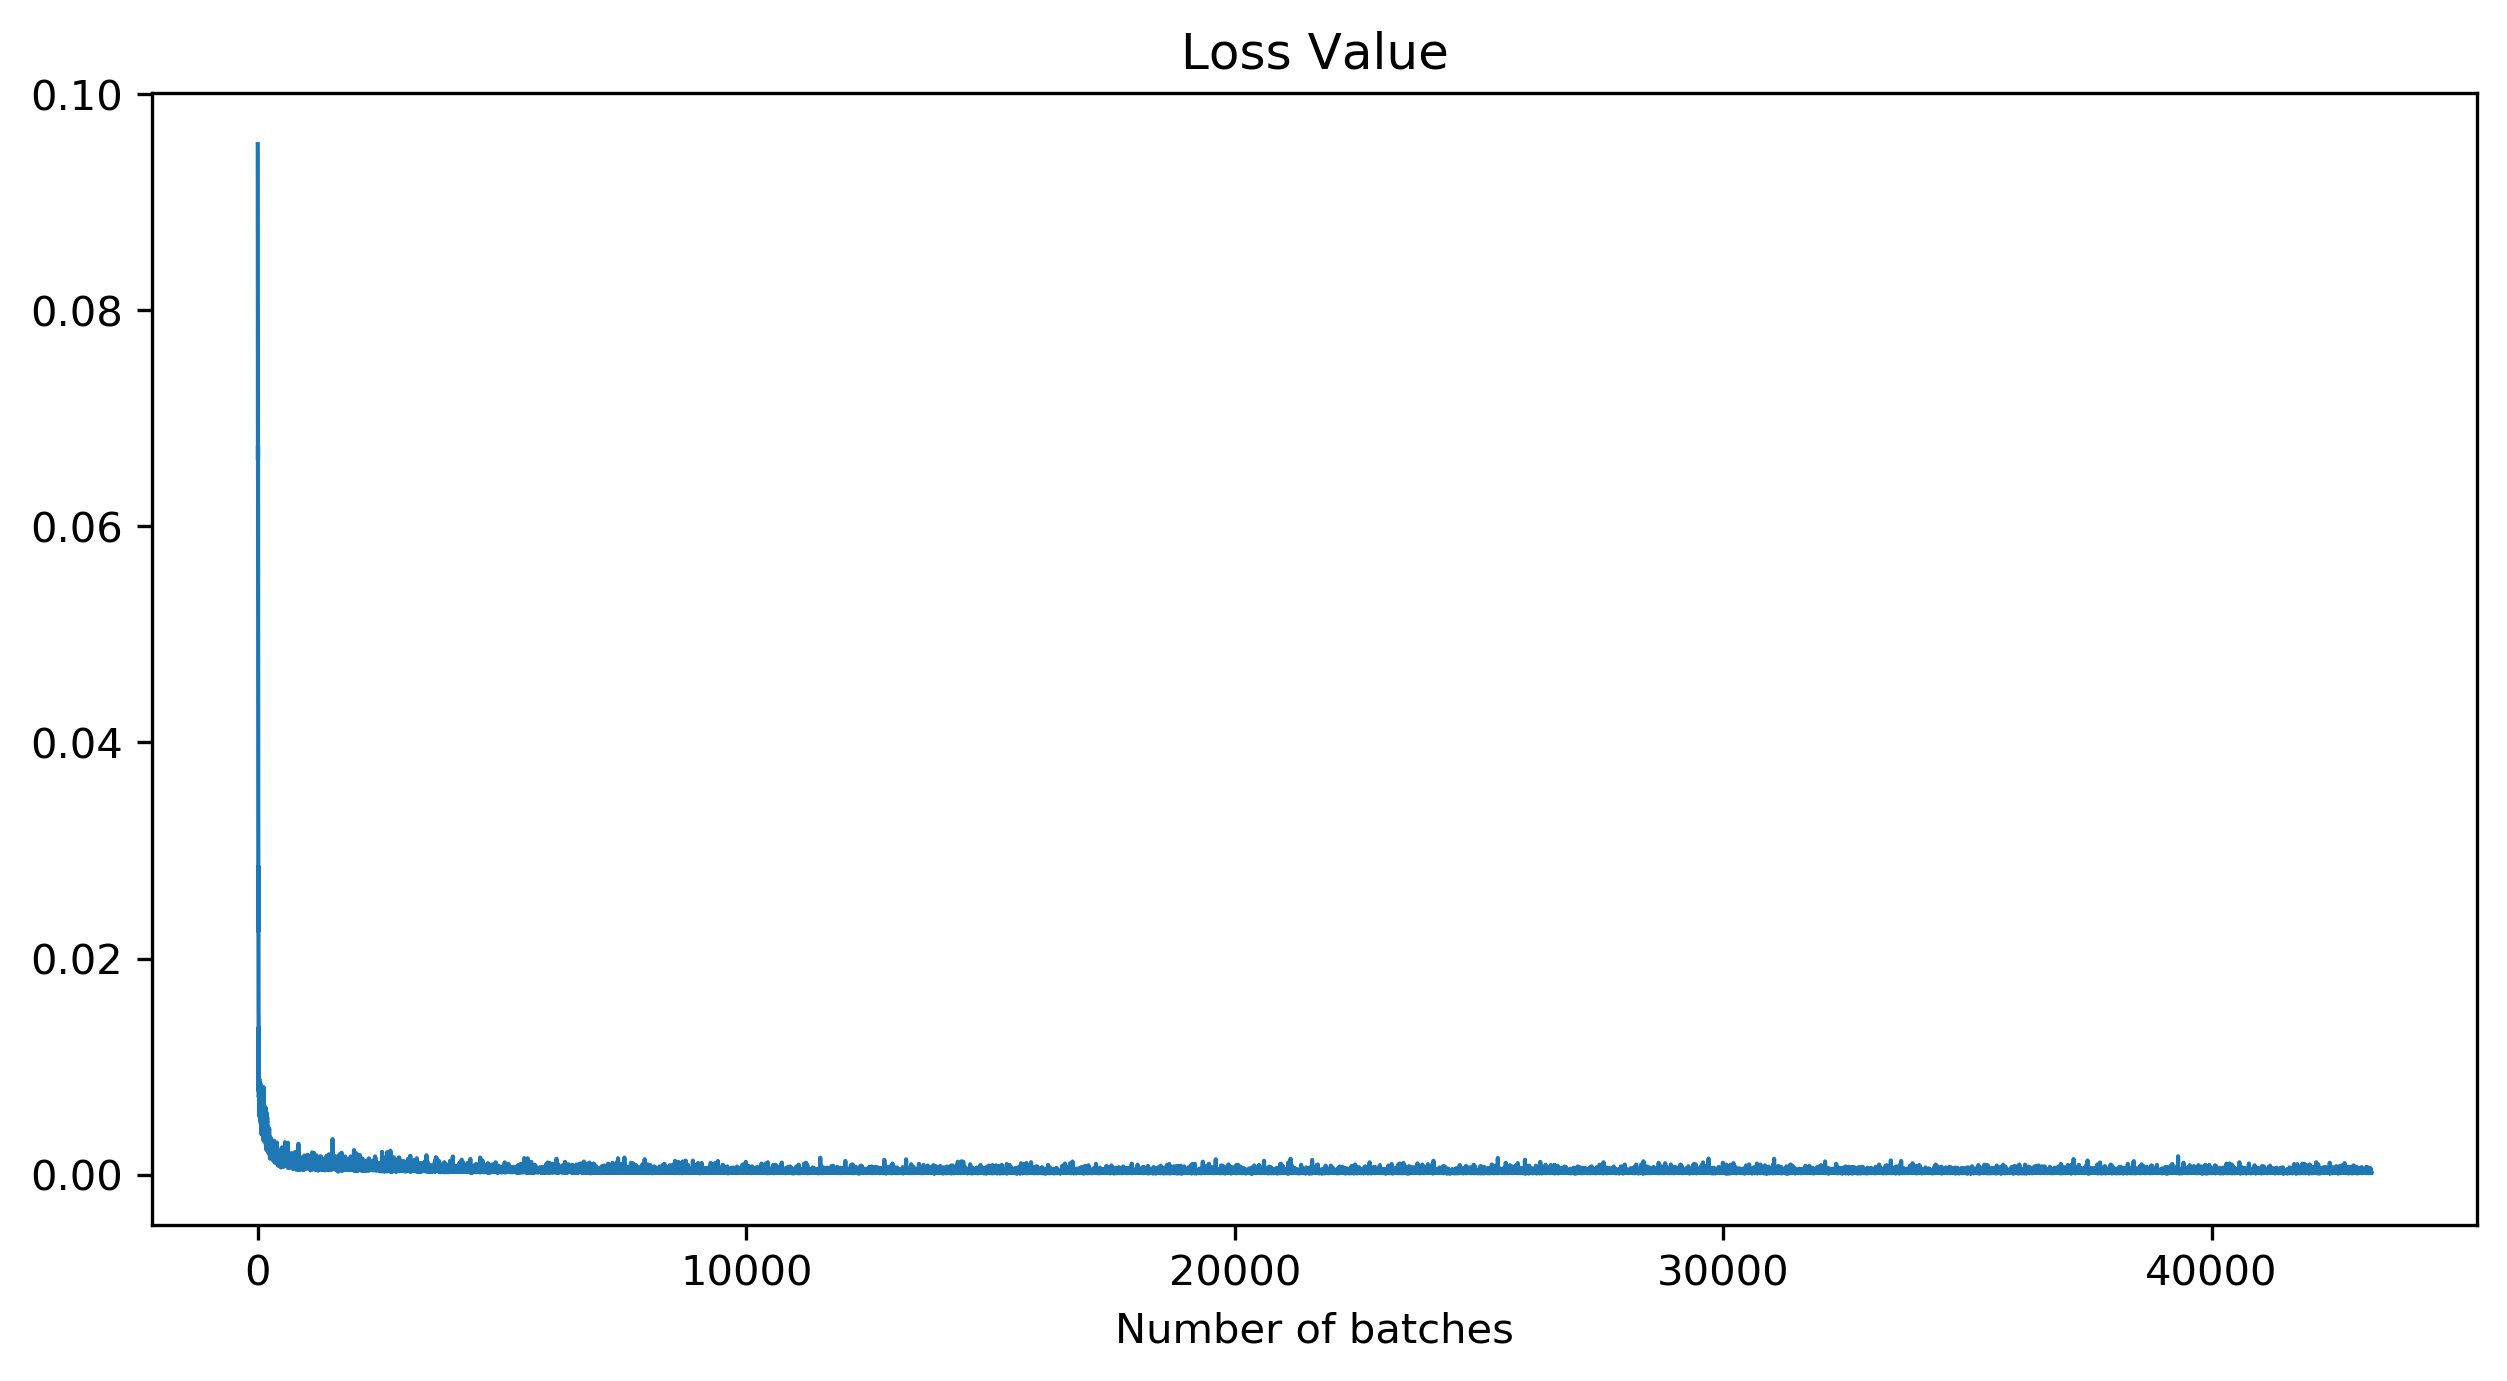

In [10]:
from matplotlib import pyplot as plt

plt.figure(figsize=(10, 5), dpi=300)
plt.plot(loss_log, linewidth=1)
plt.title('Loss Value')
plt.xlabel('Number of batches')
plt.show()

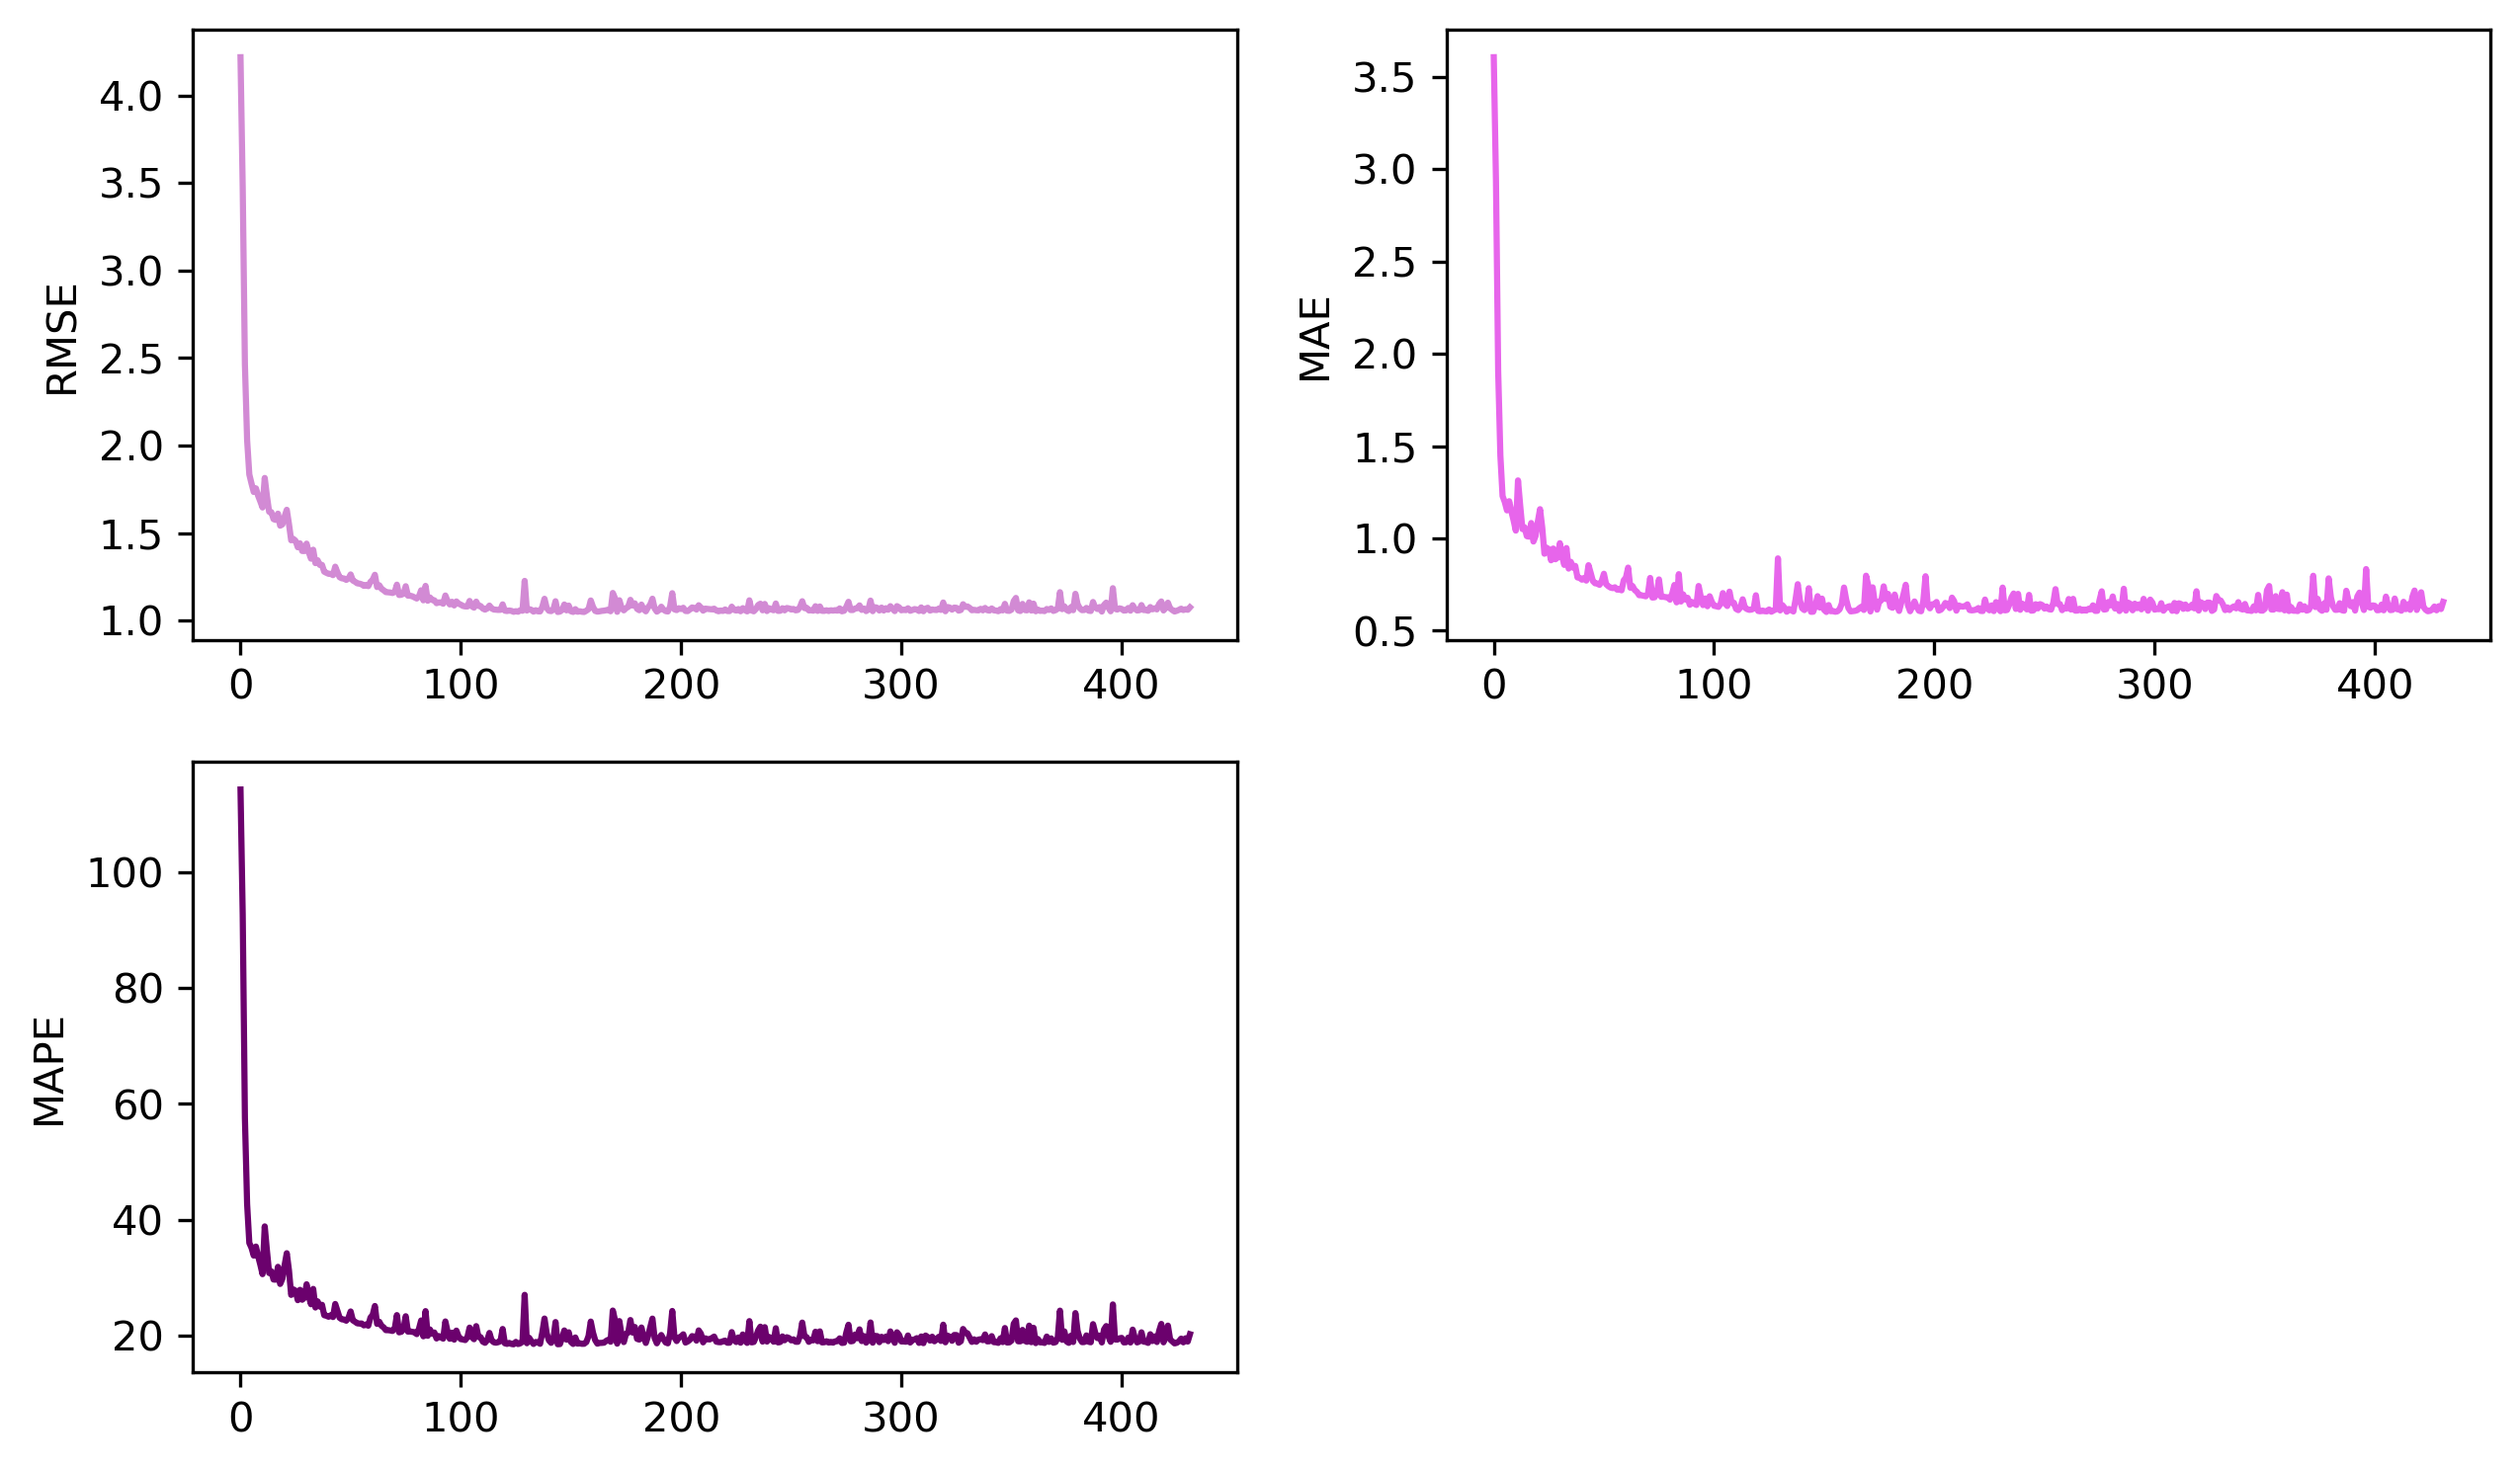

In [11]:
score_log = np.array(score_log)

plt.figure(figsize=(10, 6), dpi=300)
plt.subplot(2, 2, 1)
plt.plot(score_log[:, 0], c='#d28ad4')
plt.ylabel('RMSE')

plt.subplot(2, 2, 2)
plt.plot(score_log[:, 1], c='#e765eb')
plt.ylabel('MAE')

plt.subplot(2, 2, 3)
plt.plot(score_log[:, 2], c='#6b016d')
plt.ylabel('MAPE')

plt.show()

In [12]:
print('Best score:', best_score)

Best score: [ 1.04974193  0.60174887 18.44390601]


## PyTorch封装RNN介绍

PyTorch中已经封装了一个可开箱即用的RNN模型，并且相比起我们的版本，其对RNN的实现更加完整，其中包括：

- 多层RNN
- 双向RNN

nn.RNN的使用方式很简单，其接口与我们的版本主要区别在于：

- 多了两个参数num_layers和bidirectional，分别用于实现多层RNN和双向RNN；
- 包含参数batch_first，控制输入的格式，下面会进一步解释；
- 并没有output_size参数，下面会进一步解释。

例如初始化一个4层，双向的RNN可以用一下语句：

In [13]:
bi_rnn = nn.RNN(input_size=2, hidden_size=64, num_layers=4, bidirectional=True, batch_first=True)

其使用方法与我们的版本也稍有区别，主要包括：

- 默认状态下，输入的格式不是(batch_size, seq_len, input_size)而是(seq_len, batch_size, input_size)。batch_size维度是否在第一维由参数batch_first控制。
- 内部实现并没有输出层，因此虽然输出仍然为(output, hidden)，但output实际上就是每一步的隐藏状态。需要我们自己再实现一个输出层。
    - 输出的hidden的格式为(num_layers * num_direction, batch_size, hidden_size)。其格式不受batch_first控制。
    - output的格式与输入是一致的，即默认状态下为(seq_len, batch_size, hidden_size)。
    
使用随机生成的数据进行测试：

In [14]:
device = 'cuda:0'
batch_size = 32
seq_len = 12
input_size = 2

x = torch.randn(batch_size, seq_len, input_size).to(device)
bi_rnn = bi_rnn.to(device)
output, hidden = bi_rnn(x)
print(output.shape, hidden.shape)

torch.Size([32, 12, 128]) torch.Size([8, 32, 64])


### 使用封装的RNN进行实验

In [15]:
device = 'cuda:0'

rnn = nn.RNN(input_size=1, hidden_size=32, num_layers=1, batch_first=True).to(device)
out_linear = nn.Sequential(nn.Linear(32, 1), nn.LeakyReLU()).to(device)

loss_func = nn.MSELoss()
optimizer = torch.optim.Adam(list(rnn.parameters()) + list(out_linear.parameters()), lr=0.0001)

loss_log = []
score_log = []
trained_batches = 0
for epoch in range(10):
    for batch in next_batch(shuffle(train_set), batch_size=64):
        batch = torch.from_numpy(batch).float().to(device)  # (batch, seq_len)
        # 使用短序列的前12个值作为历史，最后一个值作为预测值。
        x, label = batch[:, :12], batch[:, -1]
        
        out, hidden = rnn(x.unsqueeze(-1))  # out: (batch_size, seq_len, hidden_size)
        out = out_linear(out[:, -1, :])
        prediction = out.squeeze(-1)  # (batch)
        
        loss = loss_func(prediction, label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_log.append(loss.detach().cpu().numpy().tolist())
        trained_batches += 1
        
        # 每训练一定数量的batch，就在测试集上测试模型效果。
        if trained_batches % 100 == 0:
            all_prediction = []
            for batch in next_batch(test_set, batch_size=64):
                batch = torch.from_numpy(batch).float().to(device)  # (batch, seq_len)
                x, label = batch[:, :12], batch[:, -1]
                
                out, hidden = rnn(x.unsqueeze(-1))  # out: (batch_size, seq_len, hidden_size)
                out = out_linear(out[:, -1, :])
                prediction = out.squeeze(-1)  # (batch)
                all_prediction.append(prediction.detach().cpu().numpy())
            all_prediction = np.concatenate(all_prediction)
            all_label = test_set[:, -1]
            # 进行反归一化操作。
            all_prediction = dataset.denormalize(all_prediction, fetch_col)
            all_label = dataset.denormalize(all_label, fetch_col)
            # 计算测试指标。
            rmse_score = math.sqrt(mse(all_label, all_prediction))
            mae_score = mae(all_label, all_prediction)
            mape_score = mape(all_label, all_prediction)
            score_log.append([rmse_score, mae_score, mape_score])
            print('RMSE: %.4f, MAE: %.4f, MAPE: %.4f' % (rmse_score, mae_score, mape_score))

best_score = np.min(score_log, axis=0)

RMSE: 4.3731, MAE: 3.6207, MAPE: 106.4294
RMSE: 5.7419, MAE: 5.0734, MAPE: 166.5684
RMSE: 4.9750, MAE: 4.3821, MAPE: 142.8890
RMSE: 3.6763, MAE: 3.2160, MAPE: 102.1478
RMSE: 2.2629, MAE: 1.6281, MAPE: 44.2734
RMSE: 2.3322, MAE: 1.7483, MAPE: 49.0717
RMSE: 2.1634, MAE: 1.5122, MAPE: 40.9147
RMSE: 2.2013, MAE: 1.6106, MAPE: 44.6613
RMSE: 2.1589, MAE: 1.5718, MAPE: 43.5753
RMSE: 2.0814, MAE: 1.4842, MAPE: 40.7435
RMSE: 2.0156, MAE: 1.4137, MAPE: 38.5538
RMSE: 1.9781, MAE: 1.3839, MAPE: 37.7773
RMSE: 2.1002, MAE: 1.5923, MAPE: 45.2978
RMSE: 1.9227, MAE: 1.3423, MAPE: 36.9648
RMSE: 1.9062, MAE: 1.3551, MAPE: 37.5107
RMSE: 1.8910, MAE: 1.3471, MAPE: 37.4779
RMSE: 1.8870, MAE: 1.3691, MAPE: 38.3678
RMSE: 1.7870, MAE: 1.2301, MAPE: 33.9695
RMSE: 1.8371, MAE: 1.3283, MAPE: 37.3600
RMSE: 1.8207, MAE: 1.3223, MAPE: 37.3183
RMSE: 1.7032, MAE: 1.1632, MAPE: 32.3168
RMSE: 1.6451, MAE: 1.0798, MAPE: 29.8887
RMSE: 1.5907, MAE: 1.0006, MAPE: 27.5279
RMSE: 1.5757, MAE: 1.0104, MAPE: 28.0234
RMSE: 1.6436

RMSE: 1.0522, MAE: 0.6119, MAPE: 18.8318
RMSE: 1.0632, MAE: 0.6365, MAPE: 19.6088
RMSE: 1.0545, MAE: 0.6204, MAPE: 19.1155
RMSE: 1.0685, MAE: 0.6447, MAPE: 19.8691
RMSE: 1.0589, MAE: 0.6316, MAPE: 19.4423
RMSE: 1.0621, MAE: 0.6320, MAPE: 19.4876
RMSE: 1.0506, MAE: 0.6086, MAPE: 18.7919
RMSE: 1.0641, MAE: 0.6366, MAPE: 19.6152
RMSE: 1.0670, MAE: 0.6457, MAPE: 19.8643
RMSE: 1.0498, MAE: 0.6034, MAPE: 18.6425
RMSE: 1.0622, MAE: 0.6364, MAPE: 19.6171
RMSE: 1.1185, MAE: 0.7402, MAPE: 22.6252
RMSE: 1.0676, MAE: 0.6516, MAPE: 20.0603
RMSE: 1.0544, MAE: 0.6109, MAPE: 18.8533
RMSE: 1.0519, MAE: 0.6061, MAPE: 18.7351
RMSE: 1.0553, MAE: 0.6124, MAPE: 18.9199
RMSE: 1.0608, MAE: 0.6220, MAPE: 19.2090
RMSE: 1.0708, MAE: 0.6466, MAPE: 19.9116
RMSE: 1.0583, MAE: 0.6264, MAPE: 19.3109
RMSE: 1.0624, MAE: 0.6317, MAPE: 19.4922
RMSE: 1.0617, MAE: 0.6284, MAPE: 19.4011
RMSE: 1.0551, MAE: 0.6050, MAPE: 18.7067
RMSE: 1.0540, MAE: 0.6052, MAPE: 18.6655
RMSE: 1.0595, MAE: 0.6228, MAPE: 19.2021
RMSE: 1.0576, MA

RMSE: 1.0581, MAE: 0.6139, MAPE: 18.9745
RMSE: 1.0537, MAE: 0.6059, MAPE: 18.6858
RMSE: 1.0530, MAE: 0.6050, MAPE: 18.6924
RMSE: 1.0618, MAE: 0.6246, MAPE: 19.3064
RMSE: 1.0588, MAE: 0.6108, MAPE: 18.8425
RMSE: 1.1288, MAE: 0.7505, MAPE: 22.9981
RMSE: 1.0695, MAE: 0.6406, MAPE: 19.7678
RMSE: 1.0766, MAE: 0.6597, MAPE: 20.3174
RMSE: 1.0606, MAE: 0.6162, MAPE: 19.0488
RMSE: 1.0585, MAE: 0.6127, MAPE: 18.9370
RMSE: 1.0589, MAE: 0.6089, MAPE: 18.8094
RMSE: 1.0594, MAE: 0.6157, MAPE: 19.0275
RMSE: 1.0671, MAE: 0.6349, MAPE: 19.6012
RMSE: 1.0572, MAE: 0.6142, MAPE: 18.9505
RMSE: 1.0561, MAE: 0.6072, MAPE: 18.6997
RMSE: 1.0600, MAE: 0.6166, MAPE: 18.9387
RMSE: 1.0557, MAE: 0.6082, MAPE: 18.7671
RMSE: 1.0652, MAE: 0.6279, MAPE: 19.3933
RMSE: 1.0576, MAE: 0.6094, MAPE: 18.7890
RMSE: 1.0600, MAE: 0.6100, MAPE: 18.8285
RMSE: 1.0776, MAE: 0.6622, MAPE: 20.3841
RMSE: 1.0779, MAE: 0.6563, MAPE: 20.2032
RMSE: 1.0605, MAE: 0.6243, MAPE: 19.2887
RMSE: 1.0680, MAE: 0.6336, MAPE: 19.5427
RMSE: 1.0821, MA

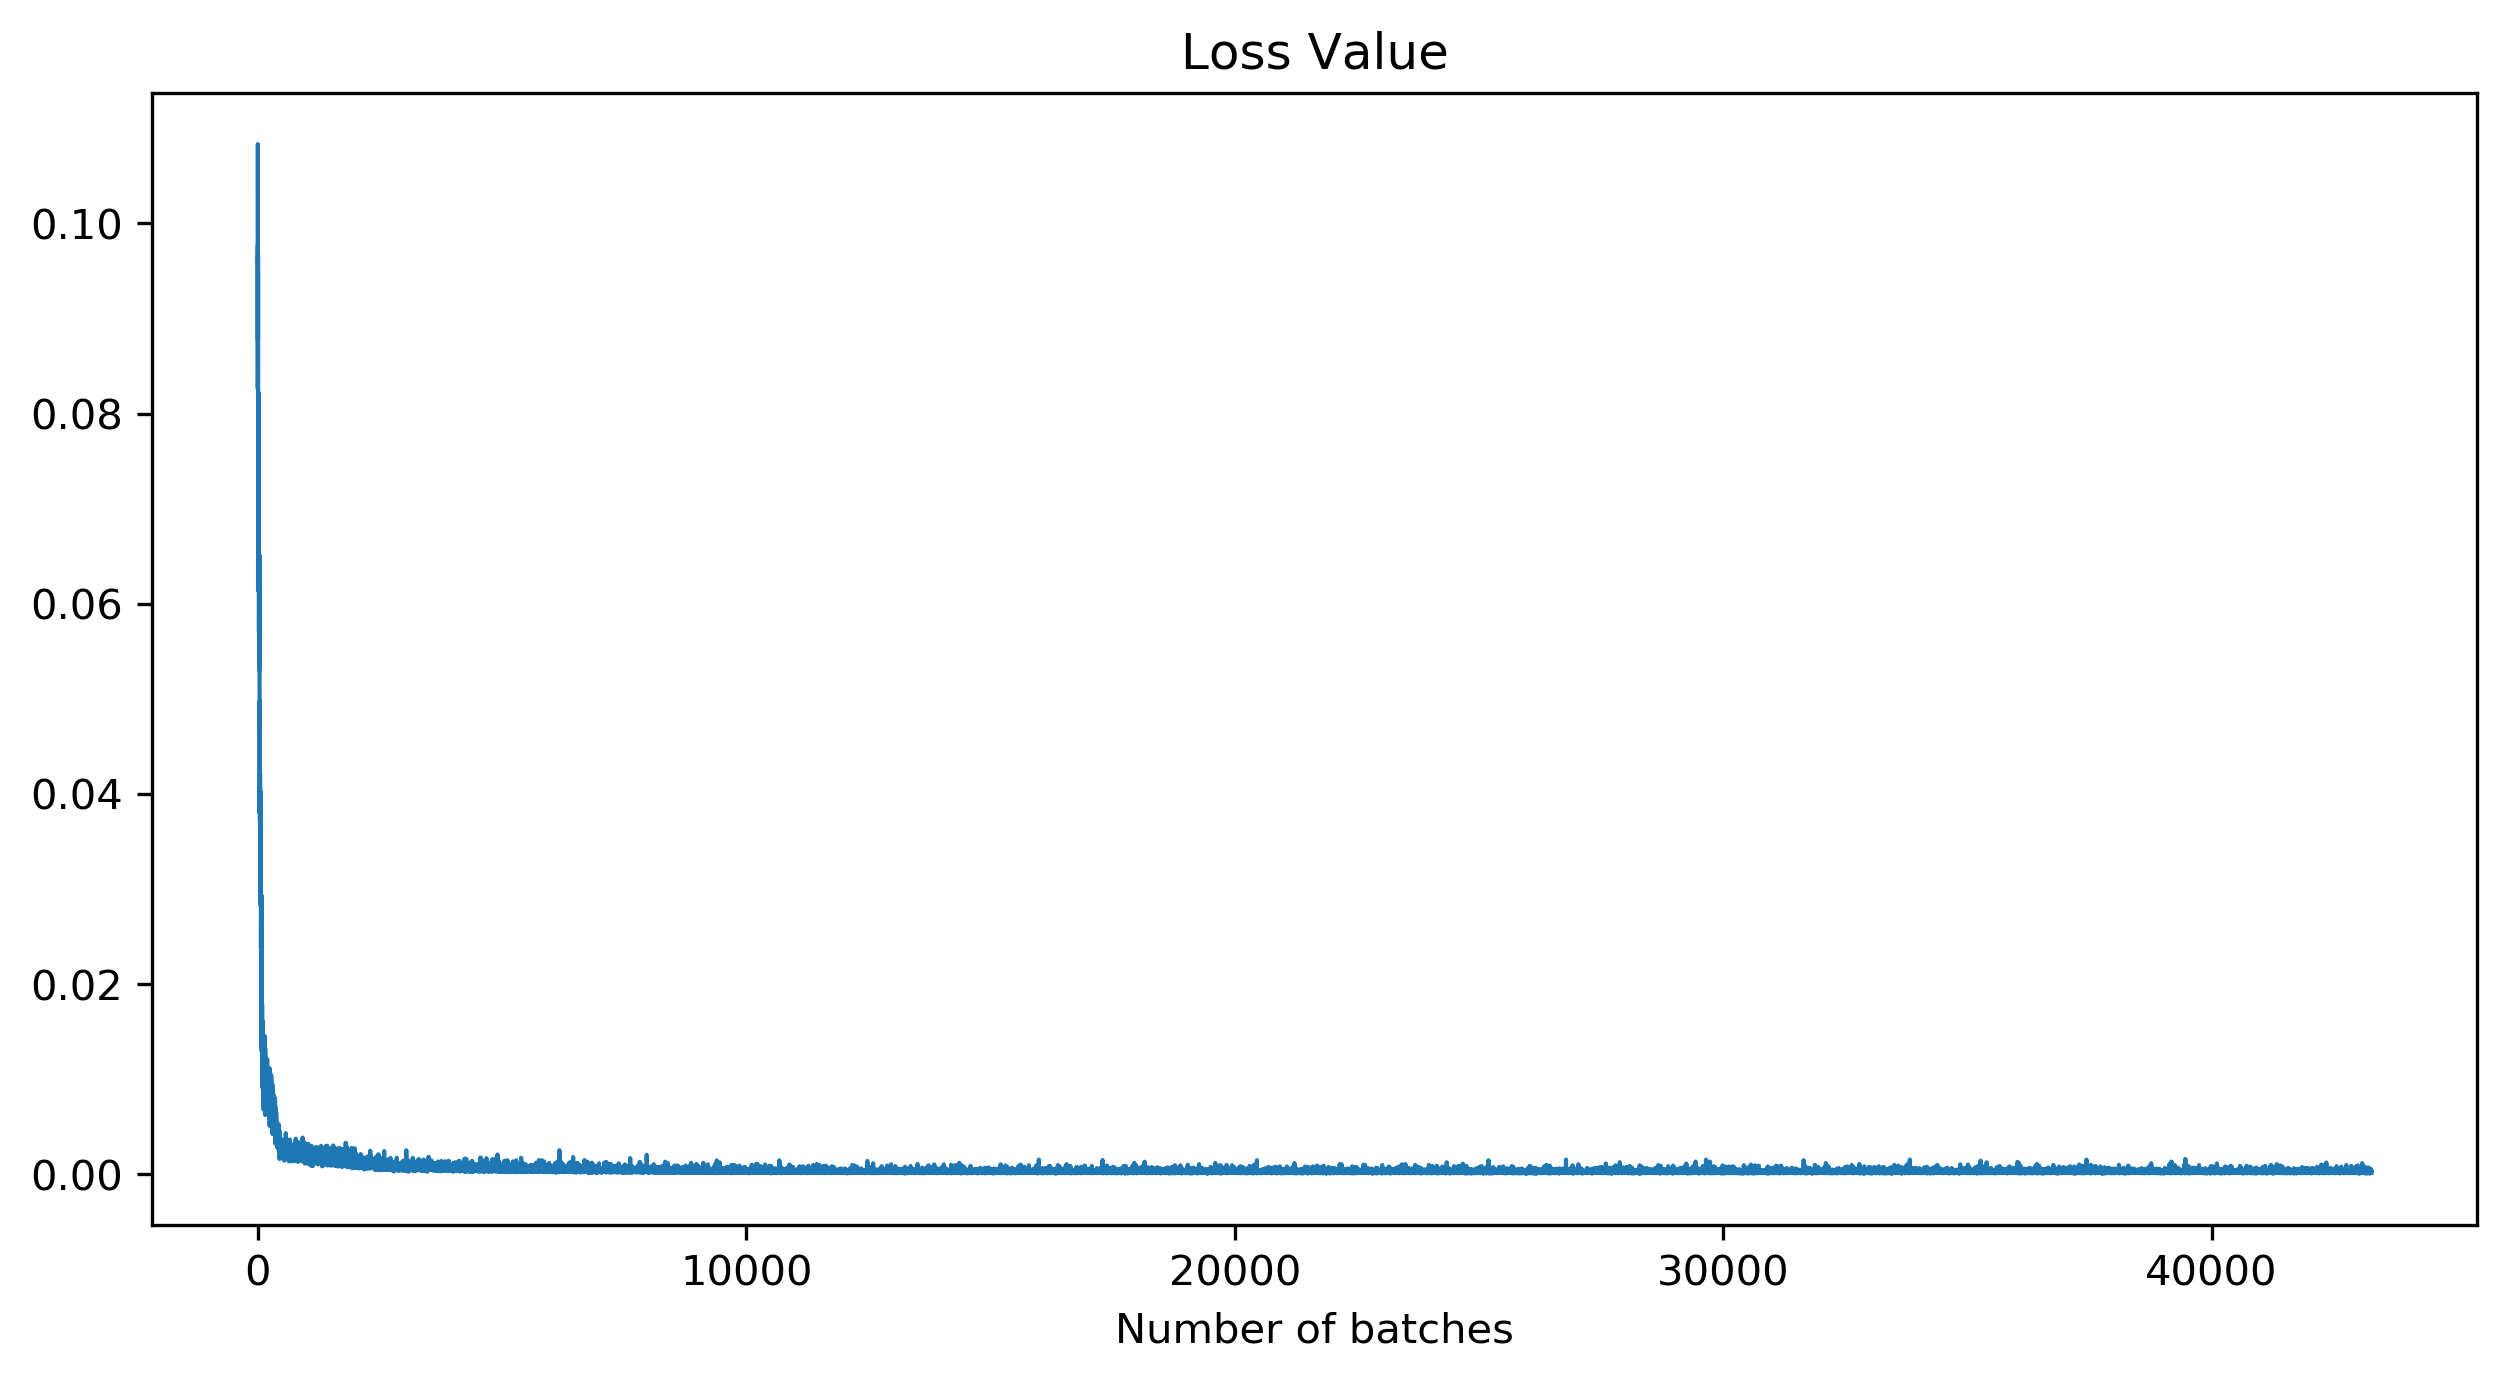

In [16]:
plt.figure(figsize=(10, 5), dpi=300)
plt.plot(loss_log, linewidth=1)
plt.title('Loss Value')
plt.xlabel('Number of batches')
plt.show()

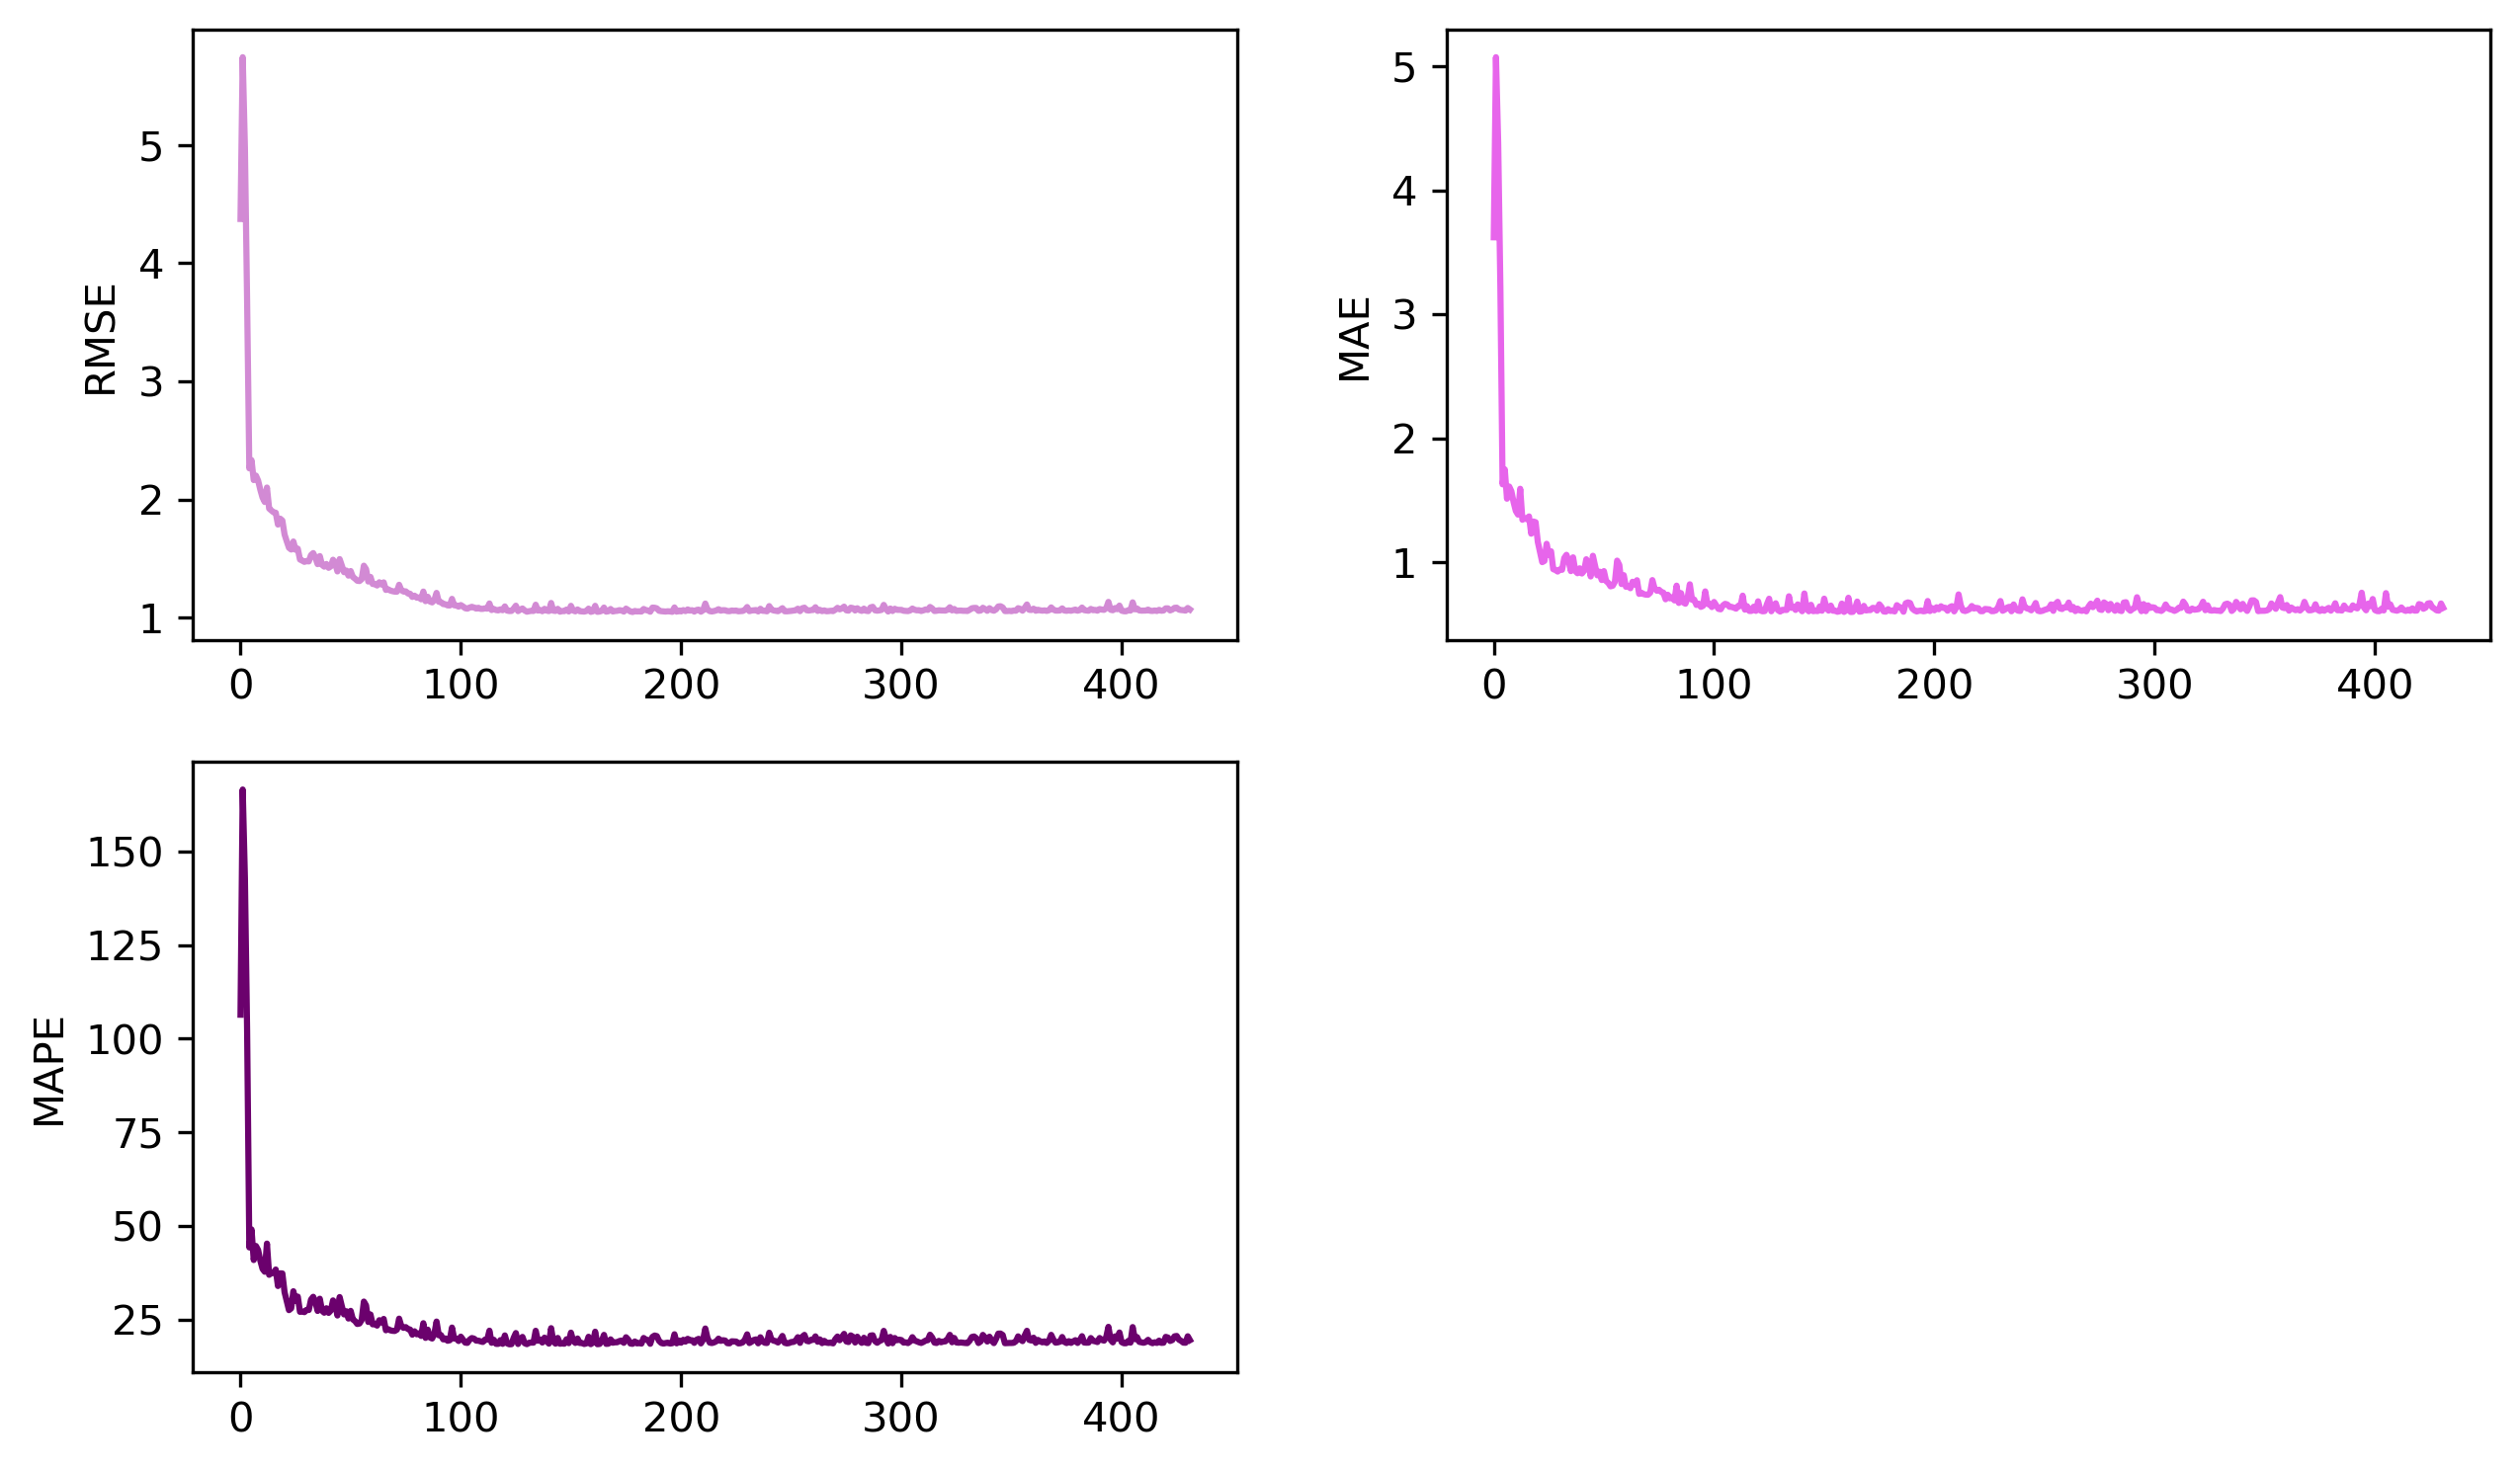

In [17]:
score_log = np.array(score_log)

plt.figure(figsize=(10, 6), dpi=300)
plt.subplot(2, 2, 1)
plt.plot(score_log[:, 0], c='#d28ad4')
plt.ylabel('RMSE')

plt.subplot(2, 2, 2)
plt.plot(score_log[:, 1], c='#e765eb')
plt.ylabel('MAE')

plt.subplot(2, 2, 3)
plt.plot(score_log[:, 2], c='#6b016d')
plt.ylabel('MAPE')

plt.show()

In [18]:
print('Best score:', best_score)

Best score: [ 1.04712744  0.5983927  18.40319872]
